## Title: The Battle of Neighborhoods

#### Introduction:
New York City is a large and ethnically diverse metropolis. It is the largest city in the United States. The
city is made up of 5 boroughs: Manhattan, Brooklyn, Queens, the Bronx and Staten Island, which were
grouped together in 1898. The population of New York City in 2020 is approximately 8.5 Million. The
New York City has been growing faster than the region over the last decade. The New York region
continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United
States. New York is the most linguistically diverse city in the world. Around 800 languages are spoken in
this city. English remains the most widely spoken language.
NYC has with its diverse culture, offers diverse food items. There are many restaurants in New York City,
serving cuisines like Chinese, Indian, and Italian etc.

#### Problem Statement:

The Background
Client: A leading Italian businessman wants to expand his business. He is keen to identify the
prime location spots in New York City to open his restaurant.
The Client is Interested in getting the answers to the below questions:
1. Identifying the neighborhoods and boroughs of New York City with highest and Lowest
number of Italian Restaurants.
2. Which neighborhood/borough provides the most ideal location to open a new Italian
Restaurant?

#### Data
For this project we need the following data to explore the New York City:

1. Dataset containing list of Boroughs and neighborhoods along with their latitude and longitude.
a. Data source: https://cocl.us/new_york_dataset
Description: The above-mentioned dataset contains the information of boroughs and
neighborhoods of NYC. We will use this data set to analyze various neighborhoods of
New York City

2. Italian restaurants in each neighborhood of New York City.
a. Data source: Foursquare API
Description: The Foursqaure API will provide all the venues in each neighborhood. We
can filter out the Italian restaurants using the category filter as required.

3. Geo Locations
a. Data source: geopy.geocoders (Python Library)
Description: This library would enable us to map the latitude and longitude information
of each neighborhood within the borough.

### Methodology

1. Collected the New York city location data from "https://cocl.us/new_york_dataset".
2. Used Python's geopy.geocoders library to get the longitude and latitude coordinates for the locations
3. Map the latitude and logitude data to each Neighbourhood
4. Using FourSquare API, extracted the Venue information of Italian Restaurants in each Neighbourhood
5. Determined the number of Italian restaurants in each neighbourhood
6. Based on the number of restaurants per neighbourhood, created bins for the level of competition the client woud face when opening a new restaurant in the neighbourhood
    - High Competition Neighborhood (denoted by 3) : No. of Italian restaurant > 9
    - Average Competition Neighborhood (denoted by 2) : No. of Italian restaurant >5 and <= 9
    - Low Competition Neighborhood (denoted by 1) : No. of Italian restaurant <= 5
7. Finally, the classification is visualized on New York City's map using Python's Folium library

##### (Important Assumption: Only the Neighborhoods with atleast one Restaurant is considered in the analysis)

#### Lets Start by importing all the required Libraries

In [53]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


#### Defining the function to get the geocodes (Latitude and Logitude Information)

In [169]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_view")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### Defining the Function to get top 100 locations within 1000 meters of the specified location using the FourSquare API

In [64]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'MMXRWWDSXOIM5H5J13OA20ATET3MPUD5DZBMUOEUPL0ETZOC' # your Foursquare ID
    CLIENT_SECRET = '3PPMEGIYZKO2HKZX0EUI3RB3SL4KJCL4TXGME20HO54JFJCX' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
     
        # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Accessing the List of Boroughs and Neighborhoods and mapping it to latitude and logitude data obtained from python's geopy

In [66]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [171]:
new_york_df=get_new_york_data()

In [173]:
new_york_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [174]:
new_york_df.shape

(306, 4)

In [75]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_food_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_food =venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_df),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_food)))
    for resturant_detail in italian_food.values.tolist():
        id, name , category=resturant_detail
        italian_food_ny = italian_food_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:2
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Restaurants in City Island, Bronx:3
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Restaurants in Fordham, Bronx:10
( 18 / 306 ) Italian Restaurants in E

( 138 / 306 ) Italian Restaurants in Richmond Hill, Queens:1
( 139 / 306 ) Italian Restaurants in Flushing, Queens:0
( 140 / 306 ) Italian Restaurants in Long Island City, Queens:3
( 141 / 306 ) Italian Restaurants in Sunnyside, Queens:2
( 142 / 306 ) Italian Restaurants in East Elmhurst, Queens:1
( 143 / 306 ) Italian Restaurants in Maspeth, Queens:2
( 144 / 306 ) Italian Restaurants in Ridgewood, Queens:3
( 145 / 306 ) Italian Restaurants in Glendale, Queens:1
( 146 / 306 ) Italian Restaurants in Rego Park, Queens:1
( 147 / 306 ) Italian Restaurants in Woodhaven, Queens:0
( 148 / 306 ) Italian Restaurants in Ozone Park, Queens:2
( 149 / 306 ) Italian Restaurants in South Ozone Park, Queens:1
( 150 / 306 ) Italian Restaurants in College Point, Queens:1
( 151 / 306 ) Italian Restaurants in Whitestone, Queens:4
( 152 / 306 ) Italian Restaurants in Bayside, Queens:3
( 153 / 306 ) Italian Restaurants in Auburndale, Queens:1
( 154 / 306 ) Italian Restaurants in Little Neck, Queens:6
( 155 

( 271 / 306 ) Italian Restaurants in Mount Hope, Bronx:0
( 272 / 306 ) Italian Restaurants in Sutton Place, Manhattan:3
( 273 / 306 ) Italian Restaurants in Hunters Point, Queens:7
( 274 / 306 ) Italian Restaurants in Turtle Bay, Manhattan:3
( 275 / 306 ) Italian Restaurants in Tudor City, Manhattan:0
( 276 / 306 ) Italian Restaurants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Italian Restaurants in Flatiron, Manhattan:2
( 278 / 306 ) Italian Restaurants in Sunnyside Gardens, Queens:3
( 279 / 306 ) Italian Restaurants in Blissville, Queens:0
( 280 / 306 ) Italian Restaurants in Fulton Ferry, Brooklyn:2
( 281 / 306 ) Italian Restaurants in Vinegar Hill, Brooklyn:2
( 282 / 306 ) Italian Restaurants in Weeksville, Brooklyn:0
( 283 / 306 ) Italian Restaurants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Italian Restaurants in Dumbo, Brooklyn:2
( 285 / 306 ) Italian Restaurants in Manor Heights, Staten Island:0
( 286 / 306 ) Italian Restaurants in Willowbrook, Staten Island:1
( 287 / 3

In [175]:
italian_food_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's


In [176]:
italian_food_ny.shape

(512, 4)

#### Displaying the No. of Italian Restaurants for each borough in the form of a horizontal bar chart

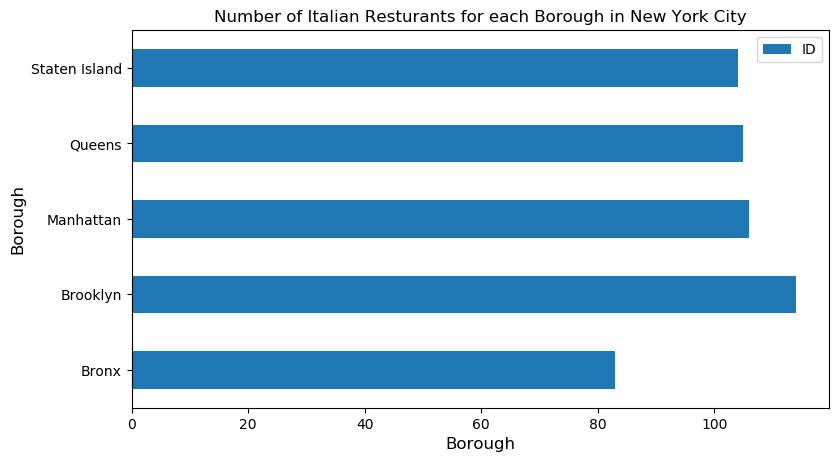

In [177]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=12)
#giving a bar plot
italian_food_ny.groupby('Borough')['ID'].count().plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

#### Displaying the top 10 Neighborhoods with highest No. of Italian Restaurants

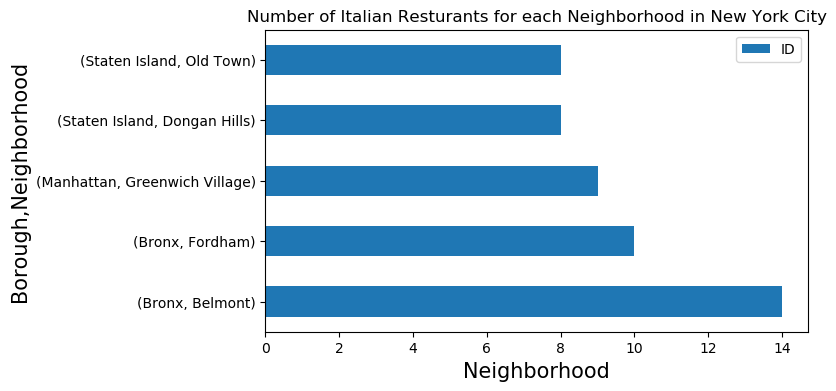

In [179]:
plt.figure(figsize=(7,4), dpi = 100)
# title
plt.title('Number of Italian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_food_ny.groupby(['Borough','Neighborhood'])['ID'].count().nlargest(5).plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

#### Creating a dataframe showing the Total No. of Italian Restaurants for the neighborhoods

In [123]:
grouped_data = italian_food_ny.groupby(['Borough','Neighborhood'], as_index = False).agg({"ID" : "count"})

In [125]:
grouped_data.head()

,Borough,Neighborhood,ID
0,Bronx,Baychester,2
1,Bronx,Belmont,14
2,Bronx,Bronxdale,5
3,Bronx,City Island,3
4,Bronx,Concourse,1


In [129]:
grouped_data.columns = ['Borough','Neighborhood','# of Italian Restaurant']

In [180]:
grouped_data.head()

,Borough,Neighborhood,# of Italian Restaurant
0,Bronx,Baychester,2
1,Bronx,Belmont,14
2,Bronx,Bronxdale,5
3,Bronx,City Island,3
4,Bronx,Concourse,1


In [181]:
grouped_data.shape

(185, 3)

In [135]:
grouped_data_final = pd.merge(new_york_data,grouped_data, left_on=['Borough','Neighborhood'],right_on=['Borough','Neighborhood'],how='inner')

In [137]:
grouped_data_final.head()

,Borough,Neighborhood,Latitude,Longitude,# of Italian Restaurant
0,Bronx,Riverdale,40.890834,-73.912585,1
1,Bronx,Kingsbridge,40.881687,-73.902818,1
2,Bronx,Woodlawn,40.898273,-73.867315,2
3,Bronx,Baychester,40.866858,-73.835798,2
4,Bronx,Pelham Parkway,40.857413,-73.854756,3


In [138]:
grouped_data_final.shape

(185, 5)

#### Creating bins for level of competition based on the No. of italian restaurants in a Neighborhood

In [148]:
bins = np.linspace(min(grouped_data_final["# of Italian Restaurant"]),max(grouped_data_final["# of Italian Restaurant"]),4)
bins

array([ 1.        ,  5.33333333,  9.66666667, 14.        ])

***To see the binning description see Methodology section in the begining***

In [160]:
bin_names = [1,2,3]

In [168]:
grouped_data_final['Competition_Level'] = pd.cut(grouped_data_final['# of Italian Restaurant'], bins, labels = bin_names, include_lowest = True)
grouped_data_final[['# of Italian Restaurant','Competition_Level']].head(10)

,# of Italian Restaurant,Competition_Level
0,1,1
1,1,1
2,2,1
3,2,1
4,3,1
5,3,1
6,10,3
7,2,1
8,1,1
9,1,1


In [162]:
grouped_data_final['Competition_Level'].value_counts()

1    168
2     15
3      2
Name: Competition_Level, dtype: int64

In [163]:
grouped_data_final.head()

,Borough,Neighborhood,Latitude,Longitude,# of Italian Restaurant,Competition_Level
0,Bronx,Riverdale,40.890834,-73.912585,1,1
1,Bronx,Kingsbridge,40.881687,-73.902818,1,1
2,Bronx,Woodlawn,40.898273,-73.867315,2,1
3,Bronx,Baychester,40.866858,-73.835798,2,1
4,Bronx,Pelham Parkway,40.857413,-73.854756,3,1


#### Using Folium Library to Visualize the Level of Competition in the Neighborhoods of New York City

In [164]:
address = 'New York City, USA'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of New York are {}, {}.'.format(latitude, longitude))

C:\Users\ASAD\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of the City of New York are 40.7127281, -74.0060152.


In [167]:
# create map of Toronto using latitude and longitude values
map_tohood = folium.Map(location=[latitude, longitude], zoom_start=10)



# add markers to map

markers_colors={}
markers_colors[1] = 'red'
markers_colors[2] = 'blue'
markers_colors[3] = 'yellow'

for lat, lng, borough, neighborhood, cluster in zip(grouped_data_final['Latitude'], grouped_data_final['Longitude'], grouped_data_final['Borough'], grouped_data_final['Neighborhood'],grouped_data_final['Competition_Level']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill=True,
        fill_opacity=0.3,
        parse_html=False).add_to(map_tohood)  
    
map_tohood

#### Yellow Markers - High Competition Neighborhood (Italian Restaurants >9)
#### Blue Markers - Medium Competition Neighborhood (Italian Restaurants <=9 and >5)
#### Red Markers - Low Competition Neighborhood (Italian Restaurants <=5)

##### Conclusion

Answering the above Questions

1. Identifying the neighborhoods and boroughs of New York City with highest and Lowest
number of Italian Restaurants.

##### Highest: Bronx, Belmont: (14 Italian Restaurants) and Fordham, Belmont: (10 Italian Restaurants)
##### Lowest: All the Neighborhoods unmarked on the New York City's map have no italian restaurant
            
2. Which neighborhood/borough provides the most ideal location to open a new Italian
Restaurant?

Most Ideal Location to open a new Italian Restaurant can be answered with the level of competition the client is looking to accept:

##### For High and Medium acceptance level of competition : The Neighborhoods marked in yellow and Blue would be ideal.
##### For Low and No acceptance level of competition : The Neighborhoods marked in red and unmraked neighborhoods would be ideal.